In [20]:
import tensorflow as tf
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 
#import albumentations as A  
import cv2
import shap
from PIL import Image

In [21]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [22]:
BATCH_SIZE = 10
IMAGE_SIZE = 512
CHANNELS=3
EPOCHS=10

In [23]:
test_directory = r"C:\\Users\\Kingstone\\Desktop\\All folder\\project work\\archive_lungs\\chest_xray\\test"
train_directory = r"C:\\Users\\Kingstone\\Desktop\\All folder\\project work\\archive_lungs\\chest_xray\\train"
val_directory = r"C:\\Users\\Kingstone\\Desktop\\All folder\\project work\\archive_lungs\\chest_xray\\val"

In [24]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, 
    shuffle = True,
    image_size = (512,512),
    batch_size = 10  
)

Found 5216 files belonging to 2 classes.


In [25]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, 
    shuffle = True,
    image_size = (512,512),
    batch_size = 10  
)

Found 624 files belonging to 2 classes.


In [26]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory, 
    shuffle = True,
    image_size = (512,512),
    batch_size = 30  
)

Found 16 files belonging to 2 classes.


In [27]:
class_name = train_data.class_names
class_name

['NORMAL', 'PNEUMONIA']

In [28]:
for image_batch, labels_batch in train_data.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(10, 512, 512, 3)
[0 0 0 1 0 0 1 1 1 1]


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 10 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

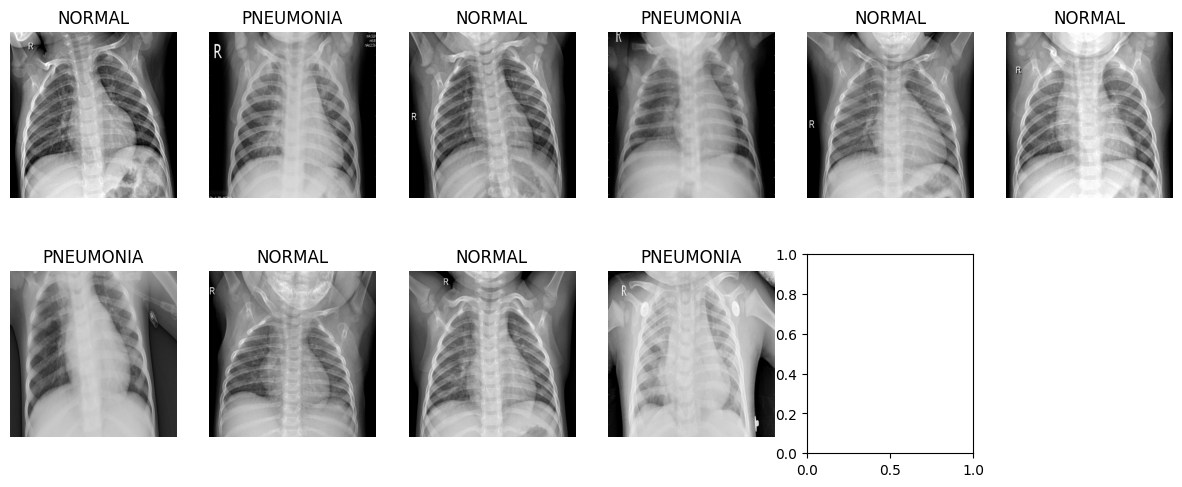

In [29]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in train_data.take(1):
    for i in range(30):
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [30]:

train_ds = train_data.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
from tensorflow.keras import layers, models

# Correct input shape without batch size
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Optional: Summary to check the model architecture
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,819 (1.20 MB)

 Trainable params: 314,819 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 485s 830ms/step - accuracy: 0.7611 - loss: 1.0724 - val_accuracy: 0.5625 - val_loss: 1.3743
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 472s 828ms/step - accuracy: 0.8856 - loss: 0.3134 - val_accuracy: 0.6250 - val_loss: 0.8510
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 467s 821ms/step - accuracy: 0.8930 - loss: 0.2627 - val_accuracy: 0.5625 - val_loss: 0.9856
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 467s 823ms/step - accuracy: 0.8992 - loss: 0.2524 - val_accuracy: 0.5625 - val_loss: 1.5459
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 479s 835ms/step - accuracy: 0.8966 - loss: 0.2572 - val_accuracy: 0.6250 - val_loss: 0.8998
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 474s 828ms/step - accuracy: 0.9137 - loss: 0.2269 - val_accuracy: 0.6875 - val_loss: 0.9164
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 483s 845ms/step - accuracy: 0.9284 - loss: 0.2061 - val_accuracy: 0.6250 - val_loss: 0.9340
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 484s 838ms/step - accuracy: 0.9299 -

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

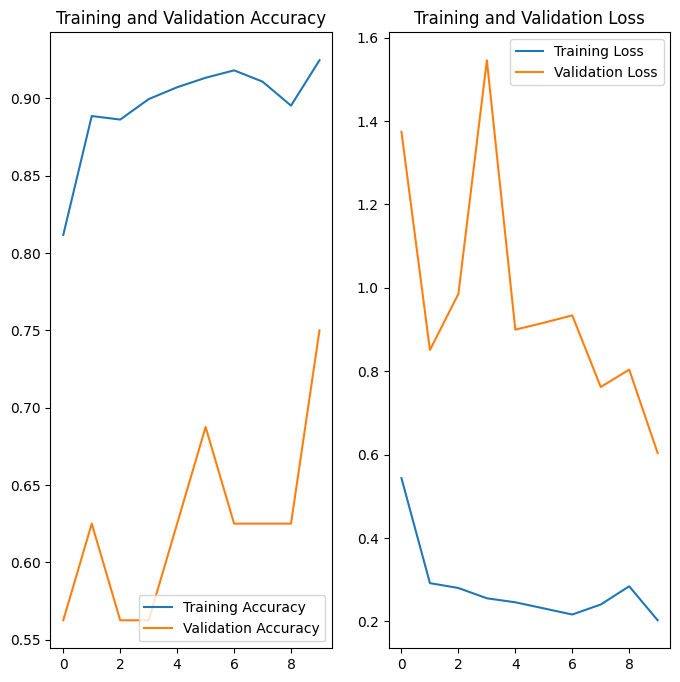

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
def extract_images(ds, num_images):
    images, _ = next(iter(ds.take(1)))
    return images[:num_images].numpy()


In [42]:
background = extract_images(train_ds, 50)
test_samples = extract_images(test_ds, 10)


In [43]:
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_samples)

c:\Users\Kingstone\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


XAI - Shap and Lime 

In [52]:
import shap
import numpy as np

# Extract images and labels from test dataset
def extract_images(ds, num_images):
    images, _ = next(iter(ds.take(1)))
    return images[:num_images].numpy()

# Extract a subset of images from the dataset
background = extract_images(train_ds, 50)  # Background dataset
test_samples = extract_images(test_ds, 10)  # Test samples to explain

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the test samples
shap_values = explainer.shap_values(test_samples)

# Generate SHAP plots

# SHAP Summary Plot
shap.summary_plot(shap_values[0], test_samples)

# SHAP Dependency Plot
shap.dependence_plot(0, shap_values[0], test_samples)

# SHAP Force Plot (first test sample)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], test_samples[0])

# SHAP Decision Plot
shap.decision_plot(explainer.expected_value[0], shap_values[0], test_samples)


: 

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

# Initialize LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Pick a sample from test dataset
for image_batch, _ in test_ds.take(1):
    test_image = image_batch[0].numpy()

# Explain a single image using LIME
explanation = explainer.explain_instance(
    test_image.astype('double'), 
    model.predict,  # The model's predict function
    top_labels=3,   # Number of classes to explain
    hide_color=0,   # Background color
    num_samples=1000  # Number of perturbed samples
)

# Visualize explanations for the top predicted class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0], 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

# Display the LIME explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()
